# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [1]:
#XVFB will be launched if you run on a server
import os

# import getpass
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
#     password = getpass.getpass()
#     command = "sudo -S bash /etc/init.d/xvfb start" # can be any command but don't forget -S as it enables input from stdin
#     os.popen(command, 'w').write(password+'\n')
#     %env DISPLAY=:1
        
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


In [2]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [4]:
policy = np.ones((n_states, n_actions)) / n_actions

In [6]:
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [7]:
def generate_session(policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [], []
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = np.random.choice(np.arange(n_actions), p=policy[s])
        
        new_s, r, done, info = env.step(a)
        
        #Record state, action and add up reward to states,actions and total_reward accordingly. 
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
            
    return states, actions, total_reward
        

In [8]:
s, a, r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float]

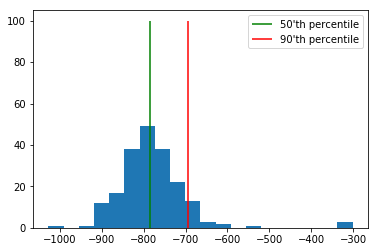

In [9]:
#let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20);
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Crossentropy method steps (2pts)

In [10]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    states_batch = np.array(states_batch)
    actions_batch = np.array(actions_batch)
    rewards_batch = np.array(rewards_batch)
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_indices = rewards_batch >= reward_threshold
    
    elite_states  = np.concatenate(states_batch[elite_indices])
    elite_actions = np.concatenate(actions_batch[elite_indices])
    
    return elite_states, elite_actions
    

In [11]:
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = [
    3,         #game1
    4,         #game2
    5,         #game3
]

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [12]:
def update_policy(elite_states, elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    new_policy = np.zeros([n_states, n_actions])
    
    for state, action in zip(elite_states, elite_actions):
        new_policy[state, action] += 1
    
    norm_coeffs = np.sum(new_policy, axis=1)
    new_policy[norm_coeffs != 0] /= norm_coeffs[norm_coeffs != 0][:, None]
    new_policy[norm_coeffs == 0] = 1. / n_actions
    
    return new_policy

In [13]:
elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [14]:
from IPython.display import clear_output

def show_progress(rewards_batch, percentile, log, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [15]:
#reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions 

In [16]:
def run_crossentropy_method(policy, n_sessions=250, percentile=50, learning_rate=0.5, n_iter=100):
    log = []

    for i in range(n_iter):

        sessions = [generate_session(policy) for _ in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = zip(*sessions)
        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
        new_policy = update_policy(elite_states, elite_actions)
        policy = learning_rate * new_policy + (1 - learning_rate) * policy

        #display results on chart
        show_progress(rewards_batch, percentile, log)
    
    return rewards_batch, log

In [17]:
def show_results(rewards_batch_list, log_list, params_list, reward_range=[-990,+10]):
    N = len(params_list)
    plt.figure(figsize=[10, 4 * N])
    
    for i in range(N):
        rewards_batch = rewards_batch_list[i]
        percentile = params_list[i]['percentile']
        log = log_list[i]
        n_sessions = params_list[i]['n_sessions']
        
        mean_reward = np.mean(rewards_batch)
        threshold = np.percentile(rewards_batch, percentile)
        
        plt.subplot(N, 2, 2*i + 1)
        plt.plot(list(zip(*log))[0],label='Mean rewards')
        plt.plot(list(zip(*log))[1],label='Reward thresholds')
        plt.title("n_sessions = {}, percentile = {}".format(n_sessions, percentile))
        plt.legend()
        plt.grid()

        plt.subplot(N, 2, 2*i + 2)
        plt.hist(rewards_batch,range=reward_range);
        plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
        plt.legend()
        plt.title("mean reward = %.3f, threshold = %.3f"%(mean_reward, threshold))
        plt.grid()
    
    plt.tight_layout(w_pad=2.0, h_pad=3.0)
    plt.show()

# Homework part 1 solution

mean reward = -457.572, threshold=6.200


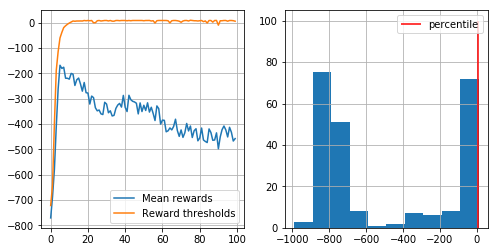

In [69]:
n_sessions_list = [50, 150, 250]
percentile_list = [20, 50, 80]
rewards_batch_list, log_list, params_list = [], [], []

for n_sessions in n_sessions_list:
    for percentile in percentile_list:
        params_list.append({'n_sessions' : n_sessions, 'percentile' : percentile})
        rewards_batch, log = run_crossentropy_method(policy, n_sessions=n_sessions,
                                                     percentile=percentile, learning_rate=0.5, n_iter=100)
        rewards_batch_list.append(rewards_batch)
        log_list.append(log)

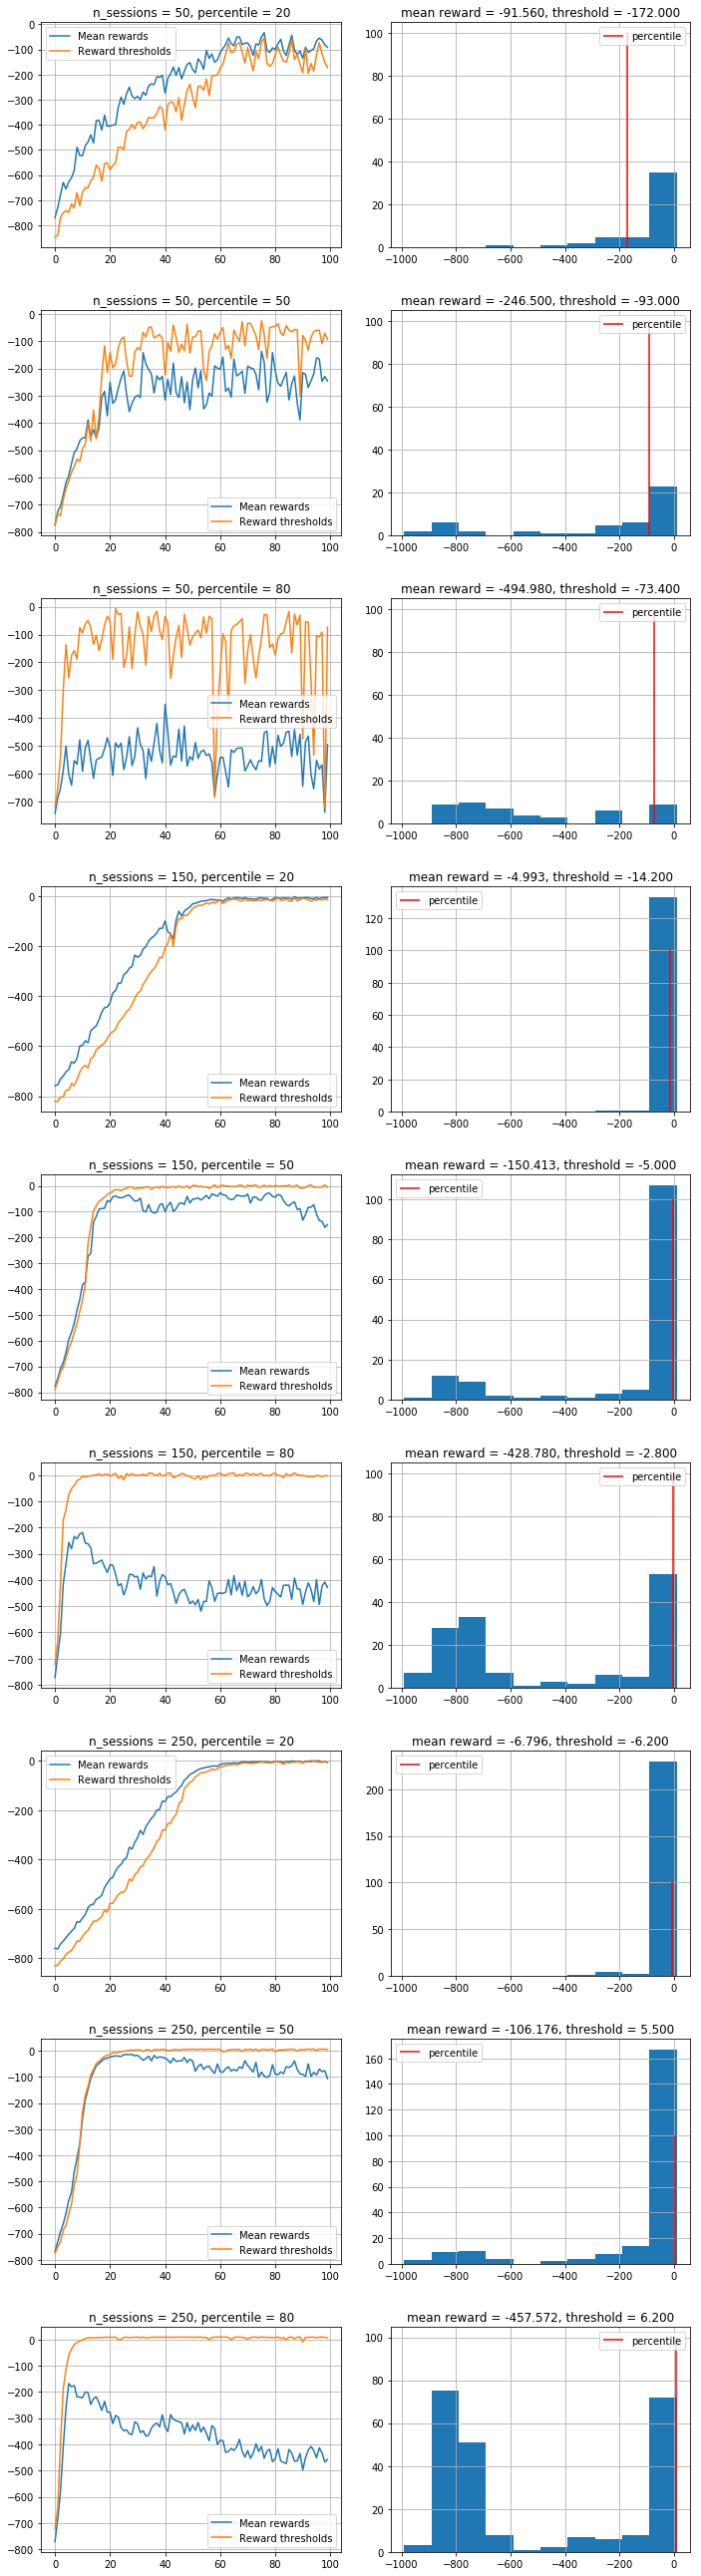

In [71]:
show_results(rewards_batch_list, log_list, params_list)

Видим, что обучение происходит тем лучше, чем меньше перцентиль, то есть чем больше примеров мы считаем элитными. Увеличение количества сессий улучшает обучение (но при этом, ясное дело, замедляет его). Заметим, что замена перцентиля с 50 на 20 решает проблему уменьшения средней награды на больших итерациях.

mean reward = 4.573, threshold=1.000


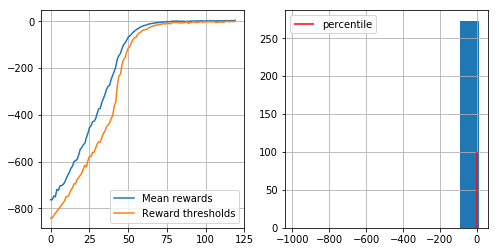

In [118]:
run_crossentropy_method(policy, n_sessions=300, percentile=15, learning_rate=0.5, n_iter=120);

Подобрали параметры обучения, чтобы средняя награда стала положительной.

# Digging deeper: approximate crossentropy with neural nets

![img](https://casd35.wikispaces.com/file/view/digging_deeper_final.jpg/359658499/503x260/digging_deeper_final.jpg)

In this section we will train a neural network policy for continuous state space game

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


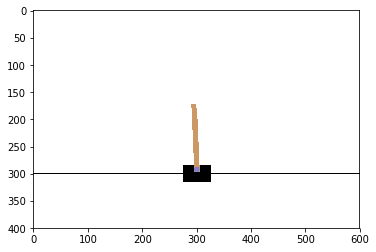

In [30]:
env = gym.make("CartPole-v0").env  #if you see "<classname> has no attribute .env", remove .env or update gym

env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In [19]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()] * n_actions, range(n_actions));


/home/bereznyuk/anaconda3/envs/rl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [20]:
def generate_session(t_max=1000):
    
    states, actions = [], []
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(range(n_actions), p=probs)
        
        new_s, r, done, info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
            
    return states, actions, total_reward
        

mean reward = 240.600, threshold=267.200


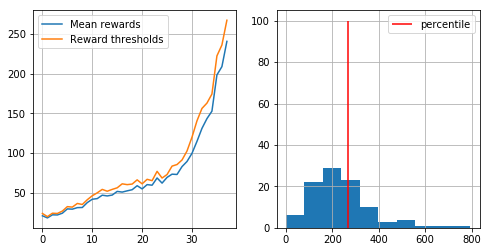

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [21]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, reward_range=[0, np.max(rewards_batch)])
    
    if np.mean(rewards_batch)> 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [57]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#upload to gym
#gym.upload("./videos/",api_key="<your_api_key>") #you'll need me later

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [58]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples.
- __1.2__ (2 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


# Solution I

Решение этой части находится вверху.

# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to upload the result and get to something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__
  * For any environment, upload it to gym and post url in your anytask form.

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (bonus: 4++ pt) Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  * __Please list what you did in anytask submission form__
  
  
### Tips
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.
* __Please upload the results to openai gym and send links to all submissions in the e-mail__

### Bonus tasks

* __2.3 bonus__ Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in anytask submission._)

* __2.4 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * Start with ["Pendulum-v0"](https://github.com/openai/gym/wiki/Pendulum-v0).
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.


If you're still feeling unchallenged, consider the project (see other notebook in this folder).

# Solution II

Все эксперименты и результаты приведены ниже.

__2.1__ Были решены обе задачи сетью с двумя скрытыми слоями по 100 нейронов каждый и с relu активацией. Количество сессий обычно равнялось 250, а перцентиль бралась равной 20. Для mountain car алгоритм обучения сети делал 1 итерацию с лёрнинг рейтом 0.001. Для lunar lander алгоритм обучения сети делал 5 итераций с лёрнинг рейтом 0.01. Также было замечено, что для решения lunar lander достаточно использовать сеть с одним скрытым слоем из 100 нейронов.

__2.2__ Я использовал Pool, чтобы параллельно генерировать лист сессий. Результаты измерений приведены в самом низу этого нотбука. Видно, что Pool дал ускорение генерации сессий более, чем в 2.5 раза. Также видно, что генерация занимает бо́льшую часть времени обучения. Поэтому обучение в целом было заметно ускорено. Можно заметить, что на более поздних стадиях обучения, когда агент уже научился доводить игру до конца за приемлимое число шагов, вклад генерации сессий в общее время обучения уменьшается. Но к этому моменту обучение уже в любом случае происходит гораздо быстрее, чем когда агент делает большое число шагов.

__2.3__ Как было отмечено выше, обе задачи были решены сетью с двумя скрытыми слоями по 100 нейронов каждый и с функцией активации relu. Но при обучении использовались различные значения лёрнинг рейта и количества итераций алгоритма обучения сети на одном примере.

In [6]:
env = gym.make('MountainCar-v0').env
env.reset()
n_actions = env.action_space.n

from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(50, 50),
                      activation='relu',
                      warm_start=True,
                      max_iter=1
                     )
agent.fit([env.reset()] * n_actions, range(n_actions));

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/bereznyuk/anaconda3/envs/rl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [18]:
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline

def generate_session(t_max=5000):
    
    states, actions = [], []
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        probs = agent.predict_proba([s])[0] 
        a = np.random.choice(range(n_actions), p=probs)
        new_s, r, done, info = env.step(a)
        
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
            
    return states, actions, total_reward

def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    states_batch = np.array(states_batch)
    actions_batch = np.array(actions_batch)
    rewards_batch = np.array(rewards_batch)
    
    if rewards_batch.size == 0:
        return [], []
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_indices = rewards_batch > reward_threshold
    
    if True in elite_indices:
        elite_states = np.concatenate(states_batch[elite_indices])
        elite_actions = np.concatenate(actions_batch[elite_indices])
    else:
        elite_states = []
        elite_actions = []
    
    return elite_states, elite_actions

In [29]:
env = gym.make('MountainCar-v0').env
env.reset()
n_actions = env.action_space.n

from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(50, 50),
                      activation='relu',
                      warm_start=True,
                      max_iter=1
                     )
agent.fit([env.reset()] * n_actions, range(n_actions));

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/bereznyuk/anaconda3/envs/rl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


mean reward = -160.752, threshold=-165.000


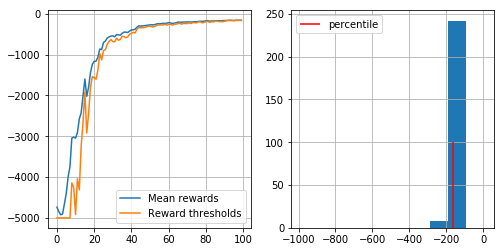

In [30]:
n_sessions = 250
percentile = 20
log = []

for i in range(100):
    with Pool() as p:
        sessions = list(p.map(generate_session, [5000] * n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    if len(elite_states) != 0:
        agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, percentile, log)
    
    if np.mean(rewards_batch) > -150:
        print("You Win! You may stop training now via KeyboardInterrupt.")

## MountainCar solution

In [31]:
env = gym.make('MountainCar-v0').env
env.reset()
n_actions = env.action_space.n

from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(100, 100),
                      activation='relu',
                      warm_start=True,
                      max_iter=1
                     )
agent.fit([env.reset()] * n_actions, range(n_actions));

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/bereznyuk/anaconda3/envs/rl/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


mean reward = -141.156, threshold=-154.000


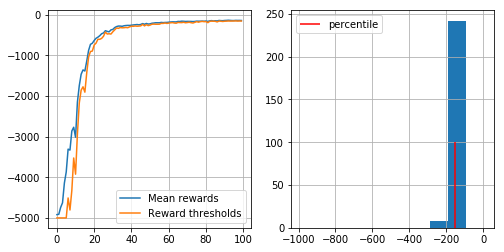

You Win! You may stop training now via KeyboardInterrupt.


In [32]:
n_sessions = 250
percentile = 20
log = []

for i in range(100):
    with Pool() as p:
        sessions = list(p.map(generate_session, [5000] * n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    if len(elite_states) != 0:
        agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, percentile, log)
    
    if np.mean(rewards_batch) > -150:
        print("You Win! You may stop training now via KeyboardInterrupt.")

In [91]:
env = gym.make('LunarLander-v2').env
env.reset()
n_actions = env.action_space.n

from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(100, 100),
                      activation='relu',
                      warm_start=True,
                      max_iter=1
                     )
agent.fit([env.reset()] * n_actions, range(n_actions));

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


mean reward = -65.729, threshold=-78.202


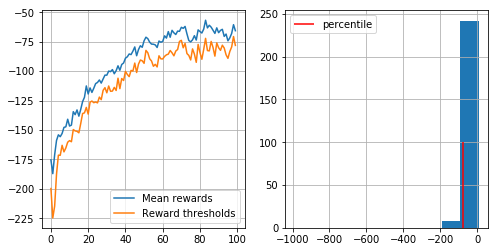

In [97]:
n_sessions = 250
percentile = 20
log = []

for i in range(100):
    with Pool() as p:
        sessions = list(p.map(generate_session, [500] * n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    if len(elite_states) != 0:
        agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, percentile, log)
    
    if np.mean(rewards_batch) > 50:
        print("You Win! You may stop training now via KeyboardInterrupt.")

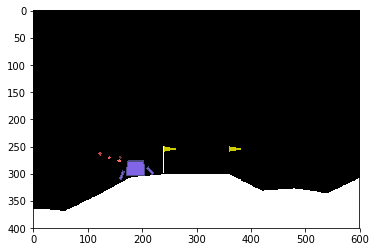

Well done!


In [103]:
TIME_LIMIT = 250

s = env.reset()

for t in range(TIME_LIMIT):
    
    # change the line below to reach the flag
    s, r, done, _ = env.step(np.random.choice(range(env.action_space.n), p=agent.predict_proba([s])[0]))
    
    #draw game image on display
    clear_output(True)
    plt.imshow(env.render('rgb_array'))
    plt.show()
    
    if done:
        print("Well done!")
        break
else:    
    print("Time limit exceeded. Try again.")

In [105]:
env = gym.make('LunarLander-v2').env
env.reset()
n_actions = env.action_space.n

from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(100, 100),
                      activation='relu',
                      warm_start=True,
                      max_iter=1
                     )
agent.fit([env.reset()] * n_actions, range(n_actions));

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


mean reward = -134.463, threshold=-156.594


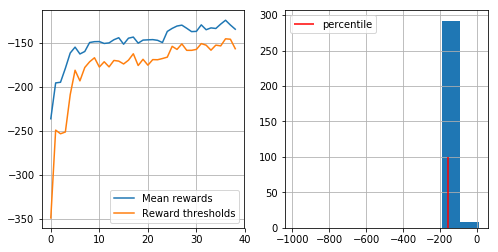

KeyboardInterrupt: 

Process ForkPoolWorker-1169:
Traceback (most recent call last):
  File "/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
 

In [107]:
n_sessions = 300
percentile = 15
log = []

for i in range(100):
    with Pool() as p:
        sessions = list(p.map(generate_session, [500] * n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    if len(elite_states) != 0:
        agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, percentile, log)
    
    if np.mean(rewards_batch) > 50:
        print("You Win! You may stop training now via KeyboardInterrupt.")

In [108]:
env = gym.make('LunarLander-v2').env
env.reset()
n_actions = env.action_space.n

from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(100,),
                      activation='relu',
                      warm_start=True,
                      max_iter=1
                     )
agent.fit([env.reset()] * n_actions, range(n_actions));

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


mean reward = -37.827, threshold=-58.100


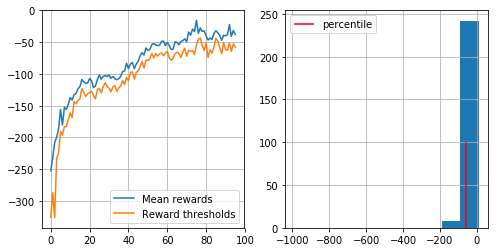

Process ForkPoolWorker-1943:
Process ForkPoolWorker-1944:
Process ForkPoolWorker-1942:
Process ForkPoolWorker-1941:
Process ForkPoolWorker-1945:
Process ForkPoolWorker-1940:
Process ForkPoolWorker-1939:
Process ForkPoolWorker-1938:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap

KeyboardInterrupt: 

In [109]:
n_sessions = 250
percentile = 20
log = []

for i in range(100):
    with Pool() as p:
        sessions = list(p.map(generate_session, [500] * n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    if len(elite_states) != 0:
        agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, percentile, log)
    
    if np.mean(rewards_batch) > 50:
        print("You Win! You may stop training now via KeyboardInterrupt.")

## Lunar lander solution with one hidden layer

In [110]:
env = gym.make('LunarLander-v2').env
env.reset()
n_actions = env.action_space.n

from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(100,),
                      activation='relu',
                      warm_start=True,
                      max_iter=5
                     )
agent.fit([env.reset()] * n_actions, range(n_actions));

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


mean reward = -4.337, threshold=-33.254


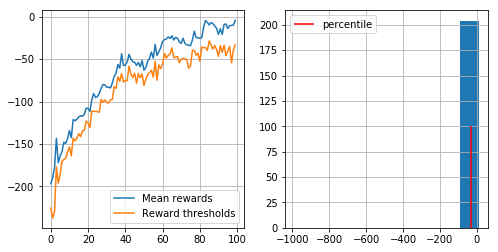

In [111]:
n_sessions = 250
percentile = 20
log = []

for i in range(100):
    with Pool() as p:
        sessions = list(p.map(generate_session, [500] * n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    if len(elite_states) != 0:
        agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, percentile, log)
    
    if np.mean(rewards_batch) > 50:
        print("You Win! You may stop training now via KeyboardInterrupt.")

Обучим ещё немного

mean reward = 66.830, threshold=6.486


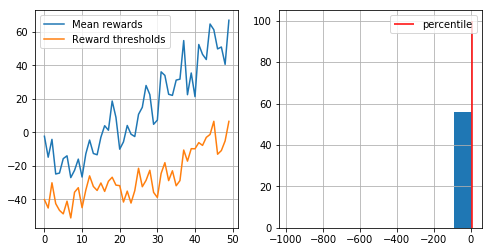

You Win! You may stop training now via KeyboardInterrupt.


In [119]:
n_sessions = 250
percentile = 20
log = []

for i in range(50):
    with Pool() as p:
        sessions = list(p.map(generate_session, [500] * n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    if len(elite_states) != 0:
        agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, percentile, log)
    
    if np.mean(rewards_batch) > 50:
        print("You Win! You may stop training now via KeyboardInterrupt.")

## Lunar lander solution with two hidden layers

In [137]:
env = gym.make('LunarLander-v2').env
env.reset()
n_actions = env.action_space.n

from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(100, 100),
                      activation='relu',
                      warm_start=True,
                      max_iter=5,
                      learning_rate_init=0.01
                     )
agent.fit([env.reset()] * n_actions, range(n_actions));

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


mean reward = 118.937, threshold=-11.424


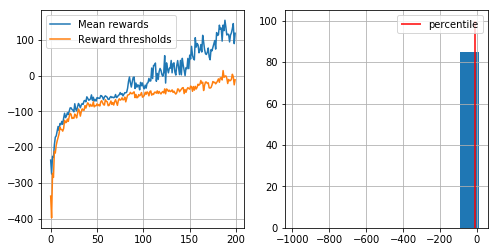

You Win! You may stop training now via KeyboardInterrupt.


In [138]:
n_sessions = 250
percentile = 20
log = []

for i in range(200):
    with Pool() as p:
        sessions = list(p.map(generate_session, [500] * n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    if len(elite_states) != 0:
        agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, percentile, log)
    
    if np.mean(rewards_batch) > 50:
        print("You Win! You may stop training now via KeyboardInterrupt.")

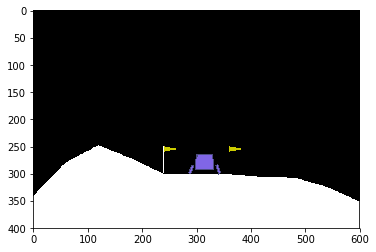

Well done!


In [139]:
TIME_LIMIT = 500

s = env.reset()

for t in range(TIME_LIMIT):
    
    # change the line below to reach the flag
    s, r, done, _ = env.step(np.random.choice(range(env.action_space.n), p=agent.predict_proba([s])[0]))
    
    #draw game image on display
    clear_output(True)
    plt.imshow(env.render('rgb_array'))
    plt.show()
    
    if done:
        print("Well done!")
        break
else:    
    print("Time limit exceeded. Try again.")

In [141]:
r

100

In [21]:
env = gym.make('MountainCar-v0').env
env.reset()
n_actions = env.action_space.n

from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(100, 100),
                      activation='relu',
                      warm_start=True,
                      max_iter=1,
                     )
agent.fit([env.reset()] * n_actions, range(n_actions));

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


mean reward = -152.236, threshold=-153.000


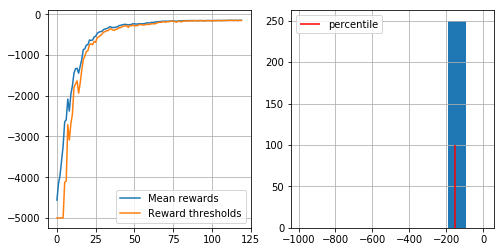

In [22]:
n_sessions = 250
percentile = 20
log = []

for i in range(120):
    with Pool() as p:
        sessions = list(p.map(generate_session, [5000] * n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    if len(elite_states) != 0:
        agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, percentile, log)
    
    if np.mean(rewards_batch) > -150:
        print("You Win! You may stop training now via KeyboardInterrupt.")

Обучим ещё немного

mean reward = -136.184, threshold=-139.000


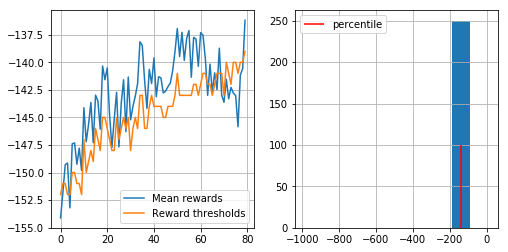

You Win! You may stop training now via KeyboardInterrupt.


In [23]:
n_sessions = 250
percentile = 20
log = []

for i in range(80):
    with Pool() as p:
        sessions = list(p.map(generate_session, [5000] * n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    if len(elite_states) != 0:
        agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, percentile, log)
    
    if np.mean(rewards_batch) > -150:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Time evaluation

In [20]:
env = gym.make('MountainCar-v0').env
env.reset()
n_actions = env.action_space.n

from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(100, 100),
                      activation='relu',
                      warm_start=True,
                      max_iter=1,
                     )
agent.fit([env.reset()] * n_actions, range(n_actions));

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/bereznyuk/anaconda3/envs/rl35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [31]:
%%timeit
n_sessions = 250

with Pool() as p:
        sessions = list(p.map(generate_session, [500] * n_sessions))

13.8 s ± 1.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%%timeit
n_sessions = 250

sessions = list(map(generate_session, [500] * n_sessions))

33.4 s ± 1.15 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit

n_sessions = 250
percentile = 20
log = []

for i in range(1):
    with Pool() as p:
        sessions = list(p.map(generate_session, [500] * n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    if len(elite_states) != 0:
        agent.fit(elite_states, elite_actions)

14.4 s ± 1.26 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Видно, что почти всё время уходит на генерацию сессий.